### Import libraries and packages

In [75]:
# import libraries and packages
import pandas as pd
import requests
from io import StringIO
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from smote_variants import MLSMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from scipy.sparse import vstack
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [9]:
# import additional requirements
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## EDA ##

In [35]:
# Define GitHub URL
url = 'https://raw.githubusercontent.com/mmoran90/ADS-509-Text-Mining/main/combined_df.csv'

# Get CSV content from GitHub
response = requests.get(url)
if response.status_code == 200:
    data = StringIO(response.text)
    maude_df = pd.read_csv(data)
    print(maude_df.head())
else:
    print(f"Error fetching data: {response.status_code}")

   MDRFOI ID                                Brand Name  \
0   20112651  HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL   
1   20112634                          XIENCE SKYPOINT¿   
2   20112157                         TRICLIP G4 SYSTEM   
3   20112156                         TRICLIP G4 SYSTEM   
4   20111290                       PERCLOSE¿ PROSTYLE¿   

                  Model Number  \
0        Model Number 1009664J   
1      Model Number 1804225-18   
2  Catalog Number TCDS0302-XTW   
3  Catalog Number TCDS0302-XTW   
4        Model Number 12773-02   

                                      Device Problem  \
0  Device Problems Difficult to Remove (1528); Ma...   
1  Device Problems Material Rupture (1546); Diffi...   
2        Device Problem Incomplete Coaptation (2507)   
3  Device Problems Positioning Failure (1158); En...   
4             Device Problem Failure to Cycle (1142)   

                                     Patient Problem             Event Date  \
0  Patient Problem Device Embe

In [36]:
# Count the number of null values in the 'CombinedDeviceProblem' column
null_count = maude_df['Device Problem'].isnull().sum()

# Print the result
print(f"Number of null values in 'Device Problem' column: {null_count}")

Number of null values in 'Device Problem' column: 1003


In [37]:
# Count the number of null values in the 'CombinedDeviceProblem' column
null_count = maude_df['Device Problems'].isnull().sum()

# Print the result
print(f"Number of null values in 'Device Problems' column: {null_count}")

Number of null values in 'Device Problems' column: 1415


In [38]:
# Combine 'DeviceProblem' and 'DeviceProblems' based on MDRFOI ID
# Use 'DeviceProblem' if available, otherwise fall back to 'DeviceProblems'
maude_df['Combined Device Problem'] = maude_df['Device Problem'].combine_first(maude_df['Device Problems'])

In [39]:
# Drop the original columns if no longer needed
maude_df.drop(['Device Problem', 'Device Problems'], axis=1, inplace=True)

In [40]:
maude_df.head()

,MDRFOI ID,Brand Name,Model Number,Patient Problem,Event Date,Event Type,Manufacturer Narrative,Event Description,Combined Device Problem
0,20112651,HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL,Model Number 1009664J,Patient Problem Device Embedded In Tissue or P...,Event Date 08/12/2024,Event Type Injury,The device was not returned for analysis.A rev...,It was reported the procedure was to treat a l...,Device Problems Difficult to Remove (1528); Ma...
1,20112634,XIENCE SKYPOINT¿,Model Number 1804225-18,"Patient Problem No Clinical Signs, Symptoms or...",Event Date 08/08/2024,Event Type malfunction,The device was not returned for evaluation.Pro...,It was reported that the procedure was to trea...,Device Problems Material Rupture (1546); Diffi...
2,20112157,TRICLIP G4 SYSTEM,Catalog Number TCDS0302-XTW,Patient Problem Tricuspid Valve Insufficiency/...,Event Date 08/14/2024,Event Type malfunction,The device was not returned for analysis.A rev...,It was reported this was a triclip procedure t...,Device Problem Incomplete Coaptation (2507)
3,20112156,TRICLIP G4 SYSTEM,Catalog Number TCDS0302-XTW,"Patient Problem No Clinical Signs, Symptoms or...",Event Date 08/12/2024,Event Type Injury,Investigation is not yet complete.A follow-up ...,It is reported this was a triclip procedure to...,Device Problems Positioning Failure (1158); En...
4,20111290,PERCLOSE¿ PROSTYLE¿,Model Number 12773-02,"Patient Problem No Clinical Signs, Symptoms or...",Event Date 08/09/2024,Event Type Injury,It was reported that this was an arteriotomy c...,Manufacturer's investigation is still pending ...,Device Problem Failure to Cycle (1142)


In [41]:
# Count the number of null values in the 'CombinedDeviceProblem' column
null_count = maude_df['Combined Device Problem'].isnull().sum()

# Print the result
print(f"Number of null values in 'CombinedDeviceProblem' column: {null_count}")

Number of null values in 'CombinedDeviceProblem' column: 423


In [87]:
# Null counts for each column
null_counts = maude_df.isnull().sum()
null_counts

,0
MDRFOI ID,0
Brand Name,0
Model Number,23
Patient Problem,101
Event Date,5
Event Type,0
Manufacturer Narrative,0
Event Description,37
Combined Device Problem,423


In [42]:
# Count rows with any missing data
rows_with_missing_data = maude_df.isna().any(axis=1).sum()

print(f"Number of rows with missing data: {rows_with_missing_data}")

Number of rows with missing data: 510


In [43]:
# Shape before dropping columns
df_shape = maude_df.shape
df_shape

(1995, 9)

In [44]:
# Remove the words "Device Problem" and "Device Problems" from the 'CombinedDeviceProblem' column
maude_df['Combined Device Problem'] = maude_df['Combined Device Problem'].str.replace('Device Problem', '', regex=False)
maude_df['Combined Device Problem'] = maude_df['Combined Device Problem'].str.replace('Device Problems', '', regex=False)
maude_df['Combined Device Problem'] = maude_df['Combined Device Problem'].str.strip()
# Also remove any leading "s " that may have been introduced
maude_df['Combined Device Problem'] = maude_df['Combined Device Problem'].str.lstrip('s ')

# Display the updated column
print(maude_df['Combined Device Problem'].head())

0    Difficult to Remove (1528); Material Separatio...
1    Material Rupture (1546); Difficult to Advance ...
2                         Incomplete Coaptation (2507)
3    Positioning Failure (1158); Entrapment of Devi...
4                              Failure to Cycle (1142)
Name: Combined Device Problem, dtype: object


In [91]:
# Create a copy of maude_df
maude_df_copy = maude_df.copy()

In [92]:
# Split the 'CombinedDeviceProblem' column by ';' into lists using the copy
maude_df_copy['Device Problems List'] = maude_df_copy['Combined Device Problem'].str.split(';')

# Display the updated DataFrame to see the separated lists
print(maude_df_copy[['Combined Device Problem', 'Device Problems List']].head())

                             Combined Device Problem  \
0  Difficult to Remove (1528); Material Separatio...   
1  Material Rupture (1546); Difficult to Advance ...   
2                       Incomplete Coaptation (2507)   
3  Positioning Failure (1158); Entrapment of Devi...   
4                            Failure to Cycle (1142)   

                                Device Problems List  
0  [Difficult to Remove (1528),  Material Separat...  
1  [Material Rupture (1546),  Difficult to Advanc...  
2                     [Incomplete Coaptation (2507)]  
3  [Positioning Failure (1158),  Entrapment of De...  
4                          [Failure to Cycle (1142)]  


In [93]:
# Remove leading/trailing whitespaces from each device problem in the list, handling NaN values
maude_df_copy['Device Problems List'] = maude_df_copy['Device Problems List'].apply(
    lambda x: [problem.strip() for problem in x] if isinstance(x, list) else x
)

# Flatten the list of all device problems into a single list, ignoring NaN values
all_device_problems = maude_df_copy['Device Problems List'].dropna().sum()

# Count the occurrences of each unique device problem
device_problem_counts = pd.Series(all_device_problems).value_counts()

# Display the counts
print(device_problem_counts)

Failure to Cycle (1142)                                          633
Material Separation (1562)                                       158
Leak/Splash (1354)                                               117
Adverse Event Without Identified Device or Use Problem (2993)    111
Difficult to Remove (1528)                                       105
Difficult to Advance (2920)                                       94
Material Rupture (1546)                                           83
Improper or Incorrect Procedure or Method (2017)                  72
Difficult to Open or Close (2921)                                 68
Incomplete Coaptation (2507)                                      51
Failure to Advance (2524)                                         47
Break (1069)                                                      45
Entrapment of Device (1212)                                       38
Off-Label Use (1494)                                              36
Unintended Movement (3026)        

In [94]:
# Get the total count of all device problems
total_device_problem_count = device_problem_counts.sum()

# Display the total count
print(f"Total device problem count: {total_device_problem_count}")

Total device problem count: 2144


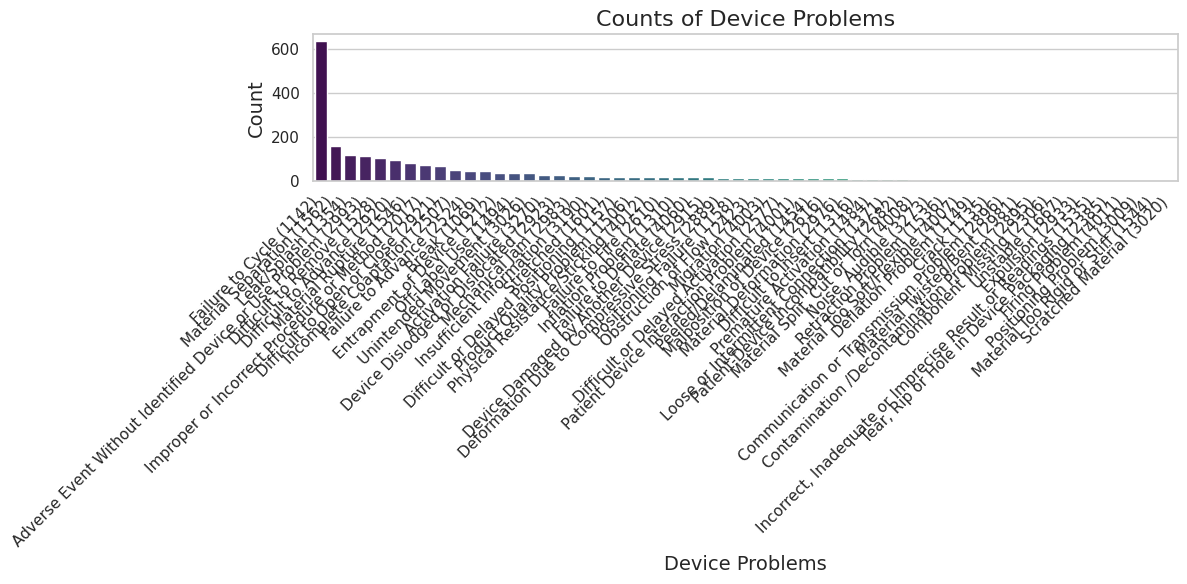

In [95]:
import warnings
warnings.filterwarnings("ignore")

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a bar plot for device problem counts
plt.figure(figsize=(12, 6))
sns.barplot(x=device_problem_counts.index, y=device_problem_counts.values, palette='viridis')

# Adding titles and labels
plt.title('Counts of Device Problems', fontsize=16)
plt.xlabel('Device Problems', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [96]:
# Remove leading/trailing whitespaces from each device problem in the list, handling NaN values
maude_df_copy['Device Problems List'] = maude_df_copy['Device Problems List'].apply(
    lambda x: [problem.strip() for problem in x] if isinstance(x, list) else x
)

# Flatten the list of all device problems into a single list, ignoring NaN values
all_device_problems = maude_df_copy['Device Problems List'].dropna().sum()

# Count the occurrences of each unique device problem
device_problem_counts = pd.Series(all_device_problems).value_counts()

# Filter to keep only device problems that appear more than 20 times
filtered_device_problem_counts = device_problem_counts[device_problem_counts > 20]

# Display the filtered counts
print(filtered_device_problem_counts)

Failure to Cycle (1142)                                          633
Material Separation (1562)                                       158
Leak/Splash (1354)                                               117
Adverse Event Without Identified Device or Use Problem (2993)    111
Difficult to Remove (1528)                                       105
Difficult to Advance (2920)                                       94
Material Rupture (1546)                                           83
Improper or Incorrect Procedure or Method (2017)                  72
Difficult to Open or Close (2921)                                 68
Incomplete Coaptation (2507)                                      51
Failure to Advance (2524)                                         47
Break (1069)                                                      45
Entrapment of Device (1212)                                       38
Off-Label Use (1494)                                              36
Unintended Movement (3026)        

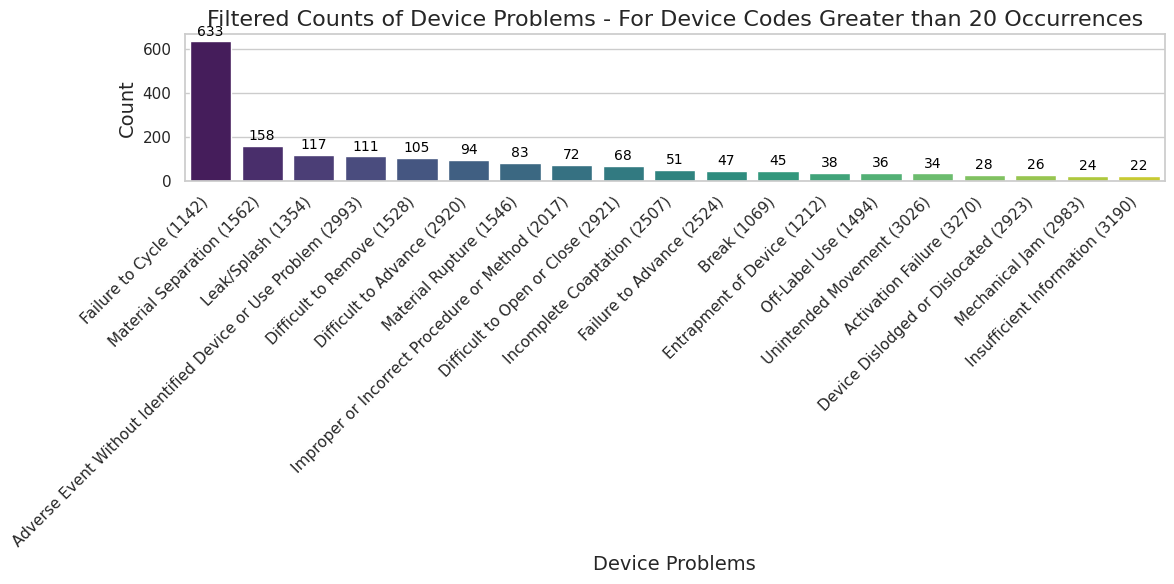

In [97]:
sns.set(style="whitegrid")

# Create a bar plot for device problem counts
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x=filtered_device_problem_counts.index, y=filtered_device_problem_counts.values, palette='viridis')

# Adding titles and labels
plt.title('Filtered Counts of Device Problems - For Device Codes Greater than 20 Occurrences', fontsize=16)
plt.xlabel('Device Problems', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add count on top of each bar
for bar in bar_plot.patches:
    bar_plot.annotate(f'{int(bar.get_height())}',
                      (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                      ha='center', va='bottom', fontsize=10, color='black',
                      xytext=(0, 2),  # 2 points vertical offset
                      textcoords='offset points')

# Show the plot
plt.show()

In [45]:
# Shape before dropping columns
df_shape = maude_df.shape
df_shape

(1995, 9)

In [46]:
# remove non-text columns that are irrelevant
maude_df.drop(['MDRFOI ID', 'Model Number', 'Event Date'], axis=1, inplace=True)

In [47]:
# Shape after dropping columns
df_shape = maude_df.shape
df_shape

(1995, 6)

In [48]:
# Drop all rows with NaN or empty values
maude_df = maude_df.dropna()
maude_df.shape

(1485, 6)

In [49]:
maude_df.head()

,Brand Name,Patient Problem,Event Type,Manufacturer Narrative,Event Description,Combined Device Problem
0,HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL,Patient Problem Device Embedded In Tissue or P...,Event Type Injury,The device was not returned for analysis.A rev...,It was reported the procedure was to treat a l...,Difficult to Remove (1528); Material Separatio...
1,XIENCE SKYPOINT¿,"Patient Problem No Clinical Signs, Symptoms or...",Event Type malfunction,The device was not returned for evaluation.Pro...,It was reported that the procedure was to trea...,Material Rupture (1546); Difficult to Advance ...
2,TRICLIP G4 SYSTEM,Patient Problem Tricuspid Valve Insufficiency/...,Event Type malfunction,The device was not returned for analysis.A rev...,It was reported this was a triclip procedure t...,Incomplete Coaptation (2507)
3,TRICLIP G4 SYSTEM,"Patient Problem No Clinical Signs, Symptoms or...",Event Type Injury,Investigation is not yet complete.A follow-up ...,It is reported this was a triclip procedure to...,Positioning Failure (1158); Entrapment of Devi...
4,PERCLOSE¿ PROSTYLE¿,"Patient Problem No Clinical Signs, Symptoms or...",Event Type Injury,It was reported that this was an arteriotomy c...,Manufacturer's investigation is still pending ...,Failure to Cycle (1142)


## Tokenizing and Descriptive Statistics



In [50]:
# Drop records with NaN values from the entire dataframe
maude_df_cleaned = maude_df.dropna()

In [53]:
maude_df_cleaned.head()

,Brand Name,Patient Problem,Event Type,Manufacturer Narrative,Event Description,Combined Device Problem,text,clean_text
0,HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL,Patient Problem Device Embedded In Tissue or P...,Event Type Injury,The device was not returned for analysis.A rev...,It was reported the procedure was to treat a l...,Difficult to Remove (1528); Material Separatio...,HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL Patie...,"[hitorque, balance, middleweight, universal, p..."
1,XIENCE SKYPOINT¿,"Patient Problem No Clinical Signs, Symptoms or...",Event Type malfunction,The device was not returned for evaluation.Pro...,It was reported that the procedure was to trea...,Material Rupture (1546); Difficult to Advance ...,XIENCE SKYPOINT¿ Patient Problem No Clinical S...,"[xience, skypoint, patient, problem, clinical,..."
2,TRICLIP G4 SYSTEM,Patient Problem Tricuspid Valve Insufficiency/...,Event Type malfunction,The device was not returned for analysis.A rev...,It was reported this was a triclip procedure t...,Incomplete Coaptation (2507),TRICLIP G4 SYSTEM Patient Problem Tricuspid Va...,"[triclip, g, system, patient, problem, tricusp..."
3,TRICLIP G4 SYSTEM,"Patient Problem No Clinical Signs, Symptoms or...",Event Type Injury,Investigation is not yet complete.A follow-up ...,It is reported this was a triclip procedure to...,Positioning Failure (1158); Entrapment of Devi...,TRICLIP G4 SYSTEM Patient Problem No Clinical ...,"[triclip, g, system, patient, problem, clinica..."
4,PERCLOSE¿ PROSTYLE¿,"Patient Problem No Clinical Signs, Symptoms or...",Event Type Injury,It was reported that this was an arteriotomy c...,Manufacturer's investigation is still pending ...,Failure to Cycle (1142),PERCLOSE¿ PROSTYLE¿ Patient Problem No Clinica...,"[perclose, prostyle, patient, problem, clinica..."


In [54]:
# Function to clean and tokenize text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    tokens = text.split()  # Tokenize text (split into words)
    return tokens

# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

In [56]:
# Combine all text columns into one for preprocessing
#maude_df_cleaned['text'] = maude_df_cleaned[['Brand Name', 'Patient Problem', 'Event Type', 'Manufacturer Narrative', 'Event Description']].fillna('').agg(' '.join, axis=1)

# Apply the clean and tokenize function to all text
maude_df_cleaned['clean_text'] = maude_df_cleaned['text'].apply(preprocess_text).apply(remove_stopwords)

# Combine descriptive text and numbers into labels
maude_df_cleaned['labels'] = maude_df_cleaned['Combined Device Problem'].apply(lambda x: x.split('; '))  # Split problems into a list

# Display a sample of the cleaned dataset
maude_df_cleaned.head()

# The 'text' column is the column that contains all non-target text columns (e.g., Patient Problem) to be pre-processed.
# The 'clean-text' column is the pre-processed' version of the 'text' column.

# The 'label' column comes from the 'Combined Device Problem' column. 
# This column contains multiple device issues (classes) for each record, such as "Difficult to Remove (1528); Material Separation (1546)". 
# These are the problems we  want to predict, so they will serve as your target variable (or label). 

,Brand Name,Patient Problem,Event Type,Manufacturer Narrative,Event Description,Combined Device Problem,text,clean_text,labels
0,HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL,Patient Problem Device Embedded In Tissue or P...,Event Type Injury,The device was not returned for analysis.A rev...,It was reported the procedure was to treat a l...,Difficult to Remove (1528); Material Separatio...,HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL Patie...,"[hitorque, balance, middleweight, universal, p...","[Difficult to Remove (1528), Material Separati..."
1,XIENCE SKYPOINT¿,"Patient Problem No Clinical Signs, Symptoms or...",Event Type malfunction,The device was not returned for evaluation.Pro...,It was reported that the procedure was to trea...,Material Rupture (1546); Difficult to Advance ...,XIENCE SKYPOINT¿ Patient Problem No Clinical S...,"[xience, skypoint, patient, problem, clinical,...","[Material Rupture (1546), Difficult to Advance..."
2,TRICLIP G4 SYSTEM,Patient Problem Tricuspid Valve Insufficiency/...,Event Type malfunction,The device was not returned for analysis.A rev...,It was reported this was a triclip procedure t...,Incomplete Coaptation (2507),TRICLIP G4 SYSTEM Patient Problem Tricuspid Va...,"[triclip, g, system, patient, problem, tricusp...",[Incomplete Coaptation (2507)]
3,TRICLIP G4 SYSTEM,"Patient Problem No Clinical Signs, Symptoms or...",Event Type Injury,Investigation is not yet complete.A follow-up ...,It is reported this was a triclip procedure to...,Positioning Failure (1158); Entrapment of Devi...,TRICLIP G4 SYSTEM Patient Problem No Clinical ...,"[triclip, g, system, patient, problem, clinica...","[Positioning Failure (1158), Entrapment of Dev..."
4,PERCLOSE¿ PROSTYLE¿,"Patient Problem No Clinical Signs, Symptoms or...",Event Type Injury,It was reported that this was an arteriotomy c...,Manufacturer's investigation is still pending ...,Failure to Cycle (1142),PERCLOSE¿ PROSTYLE¿ Patient Problem No Clinica...,"[perclose, prostyle, patient, problem, clinica...",[Failure to Cycle (1142)]


In [57]:
# Combine all tokens from all rows
all_tokens = [token for sublist in maude_df_cleaned['clean_text'].dropna() for token in sublist]

# Calculate total number of tokens
total_tokens = len(all_tokens)

# Calculate the number of unique tokens
unique_tokens = len(set(all_tokens))

# Calculate the total number of characters
total_characters = sum(len(token) for token in all_tokens)

# Calculate lexical diversity (unique tokens / total tokens)
lexical_diversity = unique_tokens / total_tokens

# Find the most common tokens
token_counts = Counter(all_tokens)
most_common_tokens = token_counts.most_common()

# Print the results
print(f"There are {total_tokens} tokens in the data.")
print(f"There are {unique_tokens} unique tokens in the data.")
print(f"There are {total_characters} characters in the data.")
print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
print(f"The most common tokens are:")
for token, count in most_common_tokens[:10]:  # Display the top 10 most common tokens
    print(f"{token}: {count}")

There are 147075 tokens in the data.
There are 4662 unique tokens in the data.
There are 1133633 characters in the data.
The lexical diversity is 0.032 in the data.
The most common tokens are:
reported: 4116
device: 3958
patient: 3531
procedure: 2396
prostyle: 2158
information: 2046
provided: 1982
additional: 1935
event: 1615
problem: 1581


In [58]:
# Shape after tokenizing
df_shape_cleaned = maude_df_cleaned.shape
df_shape_cleaned

(1485, 9)

In [59]:
# Convert lists of tokens back to strings
maude_df_cleaned['clean_text'] = maude_df_cleaned['clean_text'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)

# Verify the conversion
maude_df_cleaned.head()

,Brand Name,Patient Problem,Event Type,Manufacturer Narrative,Event Description,Combined Device Problem,text,clean_text,labels
0,HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL,Patient Problem Device Embedded In Tissue or P...,Event Type Injury,The device was not returned for analysis.A rev...,It was reported the procedure was to treat a l...,Difficult to Remove (1528); Material Separatio...,HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL Patie...,hitorque balance middleweight universal patien...,"[Difficult to Remove (1528), Material Separati..."
1,XIENCE SKYPOINT¿,"Patient Problem No Clinical Signs, Symptoms or...",Event Type malfunction,The device was not returned for evaluation.Pro...,It was reported that the procedure was to trea...,Material Rupture (1546); Difficult to Advance ...,XIENCE SKYPOINT¿ Patient Problem No Clinical S...,xience skypoint patient problem clinical signs...,"[Material Rupture (1546), Difficult to Advance..."
2,TRICLIP G4 SYSTEM,Patient Problem Tricuspid Valve Insufficiency/...,Event Type malfunction,The device was not returned for analysis.A rev...,It was reported this was a triclip procedure t...,Incomplete Coaptation (2507),TRICLIP G4 SYSTEM Patient Problem Tricuspid Va...,triclip g system patient problem tricuspid val...,[Incomplete Coaptation (2507)]
3,TRICLIP G4 SYSTEM,"Patient Problem No Clinical Signs, Symptoms or...",Event Type Injury,Investigation is not yet complete.A follow-up ...,It is reported this was a triclip procedure to...,Positioning Failure (1158); Entrapment of Devi...,TRICLIP G4 SYSTEM Patient Problem No Clinical ...,triclip g system patient problem clinical sign...,"[Positioning Failure (1158), Entrapment of Dev..."
4,PERCLOSE¿ PROSTYLE¿,"Patient Problem No Clinical Signs, Symptoms or...",Event Type Injury,It was reported that this was an arteriotomy c...,Manufacturer's investigation is still pending ...,Failure to Cycle (1142),PERCLOSE¿ PROSTYLE¿ Patient Problem No Clinica...,perclose prostyle patient problem clinical sig...,[Failure to Cycle (1142)]


## Prep Data for Modeling

In [60]:
# Binarize labels (i.e., convert data into binary matrix for multi-label classification)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(maude_df_cleaned['labels'])

# The fit_transform() converts these lists into a binary matrix, where each unique label becomes a column, and each row has a value of 1 or 0
# indicating whether that label applies to that instance.

### Split data with stratification rebalance ###

In [61]:
# pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [62]:
# Continue with the stratified split
mlskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in mlskf.split(maude_df_cleaned['clean_text'], y):
    X_train, X_test = maude_df_cleaned['clean_text'].iloc[train_index], maude_df_cleaned['clean_text'].iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Verify the split
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (1187,), Test set size: (298,)


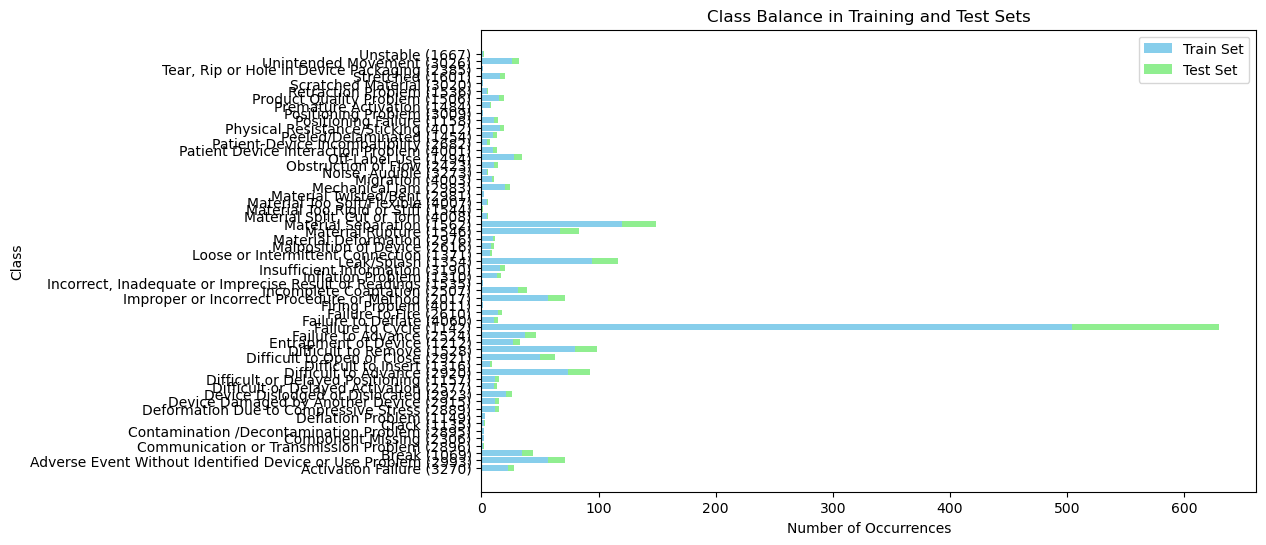

In [63]:
# Count occurrences of each class in the training set
train_class_counts = np.sum(y_train, axis=0)
test_class_counts = np.sum(y_test, axis=0)

# Get the class names
class_names = mlb.classes_

# Plot the class distribution for the training set
plt.figure(figsize=(10, 6))
plt.barh(class_names, train_class_counts, color='skyblue', label='Train Set')
plt.barh(class_names, test_class_counts, color='lightgreen', left=train_class_counts, label='Test Set')
plt.xlabel('Number of Occurrences')
plt.ylabel('Class')
plt.title('Class Balance in Training and Test Sets')
plt.legend()
plt.show()

### Split data with weight class rebalance ###

In [64]:
# Split the data into training and test sets
X_train_weights, X_test_weights, y_train_weights, y_test_weights = train_test_split(
    maude_df_cleaned['clean_text'], y, test_size=0.3, random_state=42)

# Apply TF-IDF transformation with greater weight for frequent tokens
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', sublinear_tf=True)
X_train_tfidf_weights = tfidf.fit_transform(X_train_weights)
X_test_tfidf_weights = tfidf.transform(X_test_weights)

# Verify the split
print(f"X_train_weights size: {X_train_tfidf_weights.shape}, y_train_weights size: {y_train_weights.shape}")
print(f"X_test_weights size: {X_test_tfidf_weights.shape}, y_test_weights size: {y_test_weights.shape}")

X_train_weights size: (1039, 3753), y_train_weights size: (1039, 57)
X_test_weights size: (446, 3753), y_test_weights size: (446, 57)


In [65]:
# Now, lets rebalanace the dataset using class weights since other techniques resulted in errors

# Compute class weights for each label
class_weights = []
for i in range(y_train_weights.shape[1]):
    weights = compute_class_weight('balanced', classes=np.unique(y_train_weights[:, i]), y=y_train_weights[:, i])
    class_weights.append(dict(enumerate(weights)))

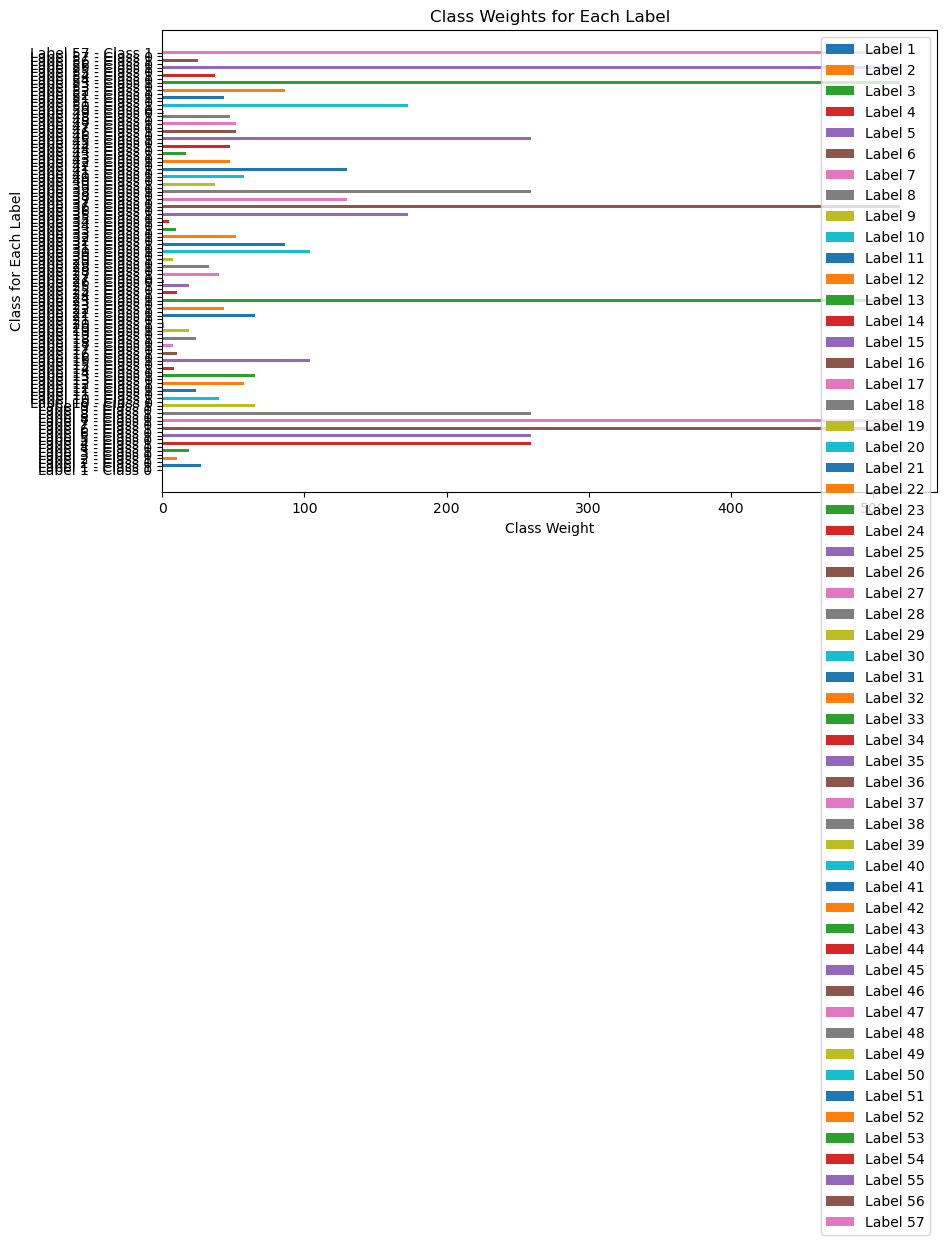

In [66]:
# Create a plot for class weights
plt.figure(figsize=(10, 6))

# Plot weights for each label separately
for i, class_weight in enumerate(class_weights):
    class_ids = list(class_weight.keys())
    weights = list(class_weight.values())
    plt.barh([f'Label {i+1} - Class {cid}' for cid in class_ids], weights, label=f'Label {i+1}')

plt.xlabel('Class Weight')
plt.ylabel('Class for Each Label')
plt.title('Class Weights for Each Label')
plt.legend(loc='best')
plt.show()

### Split Data with Oversampling of Minority Classes ###

In [233]:
# create multiple rows if a single device has multiple problems (one problem per row)
maude_df_cleaned_flat = maude_df_cleaned.explode('labels').reset_index(drop=True)

In [235]:
# Encode the labels as multi-label binarized (one-hot encoding for multi-label)
mlb = MultiLabelBinarizer()
y_mlb = mlb.fit_transform(maude_df_cleaned_flat['labels'].apply(lambda x: [x]))

In [236]:
# Split the data into training and test sets
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    maude_df_cleaned_flat ['clean_text'], y_mlb, test_size=0.3, random_state=42)

# Apply TF-IDF transformation to the text data
tfidf_over = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf_over = tfidf_over.fit_transform(X_train_over).toarray()  # Convert to dense matrix for SMOTE
X_test_tfidf_over = tfidf_over.transform(X_test_over)

In [ ]:
# Apply MultiLabelSMOTE
mlsmote = MLSMOTE(random_state=42)
X_resampled, y_resampled = mlsmote.sample(X_train_tfidf, y_train)

# Check the shape after oversampling
print(f"Resampled X shape: {X_resampled.shape}, Resampled y shape: {y_resampled.shape}")


## Build SMV Classification Model ##

In [161]:
# Remove labels with one class
valid_labels = [i for i in range(y_train_weights.shape[1]) if len(np.unique(y_train_weights[:, i])) > 1]

# Filter X_train and y_train
y_train_filtered = y_train_weights[:, valid_labels]
y_test_filtered = y_test_weights[:, valid_labels]

In [162]:
# Build SVM model (with OneVsRestClassifier for multi-label classification)
svm_model = SVC(kernel='linear', random_state=42, class_weight='balanced')
multi_svm = MultiOutputClassifier(svm_model)

# Train the model
multi_svm.fit(X_train_tfidf_weights, y_train_filtered)

MultiOutputClassifier(estimator=SVC(class_weight='balanced', kernel='linear',
                                    random_state=42))

In [163]:
# Predict on the test set
y_pred_svm = multi_svm.predict(X_test_tfidf_weights)

# Evaluate accuracy (note: accuracy is not always a good metric for multi-label classification)
accuracy = accuracy_score(y_test_filtered, y_pred_svm)

# Generate the classification report
classification_rep = classification_report(y_test_filtered, y_pred_svm, target_names=[mlb.classes_[i] for i in valid_labels])

print(f"Accuracy: {accuracy}\n")
print("Classification Report:\n", classification_rep)

Accuracy: 0.6434977578475336

Classification Report:
                                                              precision    recall  f1-score   support

                                    Activation Failure 3270       0.50      0.67      0.57         9
Adverse Event Without Identified Device or Use Problem 2993       0.82      0.64      0.72        22
                                                 Break 1069       0.90      0.56      0.69        16
                 Communication or Transmission Problem 2896       0.00      0.00      0.00         0
                                     Component Missing 2306       0.00      0.00      0.00         0
                Contamination /Decontamination Problem 2895       0.00      0.00      0.00         1
                                                 Crack 1135       0.00      0.00      0.00         2
                                     Deflation Problem 1149       0.00      0.00      0.00         1
                 Deformation Due to 

C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-package

## Build XGBoost Classification Model ##

In [168]:
# Initialize a single XGBClassifier with default parameters
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Use MultiOutputClassifier to handle multi-label classification
multi_xgb = MultiOutputClassifier(xgb_model)

# Train the XGBoost model
multi_xgb.fit(X_train_tfidf_weights, y_train_filtered)

C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [169]:
# Predict on the test set
y_pred_xgb = multi_xgb.predict(X_test_tfidf_weights)

# Evaluate the model
classification_rep_xgb = classification_report(y_test_filtered, y_pred_xgb, target_names=[mlb.classes_[i] for i in valid_labels])

print("Classification Report for XGBoost:\n", classification_rep_xgb)

Classification Report for XGBoost:
                                                              precision    recall  f1-score   support

                                    Activation Failure 3270       1.00      0.22      0.36         9
Adverse Event Without Identified Device or Use Problem 2993       0.93      0.59      0.72        22
                                                 Break 1069       0.89      0.50      0.64        16
                 Communication or Transmission Problem 2896       0.00      0.00      0.00         0
                                     Component Missing 2306       0.00      0.00      0.00         0
                Contamination /Decontamination Problem 2895       0.00      0.00      0.00         1
                                                 Crack 1135       0.00      0.00      0.00         2
                                     Deflation Problem 1149       0.00      0.00      0.00         1
                 Deformation Due to Compressive Stress

C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-package

### XGBoost with Weights ###

In [197]:
# Initialize an empty list to store class weights for each label
scale_pos_weights = []

# Compute class weights for each label
for i in range(y_train_filtered.shape[1]):
    # Compute class weights: 'balanced' returns weights inversely proportional to class frequencies
    weights = compute_class_weight('balanced', classes=np.unique(y_train_filtered[:, i]), y=y_train_filtered[:, i])
    
    # The scale_pos_weight for XGBoost is the ratio of negative to positive samples
    scale_pos_weights.append(weights[1] / weights[0])

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_tfidf_weights, label=y_train_filtered)


In [198]:
# Initialize XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': np.mean(scale_pos_weights),  # Apply mean of class weights across all labels
}

# Train XGBoost model
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=100)

# Create DMatrix for test set
dtest = xgb.DMatrix(X_test_tfidf_weights)

In [200]:
# Predict on the test set
y_pred = (xgb_model.predict(dtest) > 0.5).astype(int)  # Apply threshold for binary classification

# Calculate the overall accuracy
accuracy = accuracy_score(y_test_filtered, y_pred)

# Generate the classification report
classification_rep = classification_report(y_test_filtered, y_pred, target_names=[f'Label {i}' for i in range(y_test_filtered.shape[1])])

# Print the overall accuracy and classification report
print(f"Overall Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

Overall Accuracy: 0.6524663677130045
Classification Report:
               precision    recall  f1-score   support

     Label 0       0.45      0.56      0.50         9
     Label 1       0.74      0.64      0.68        22
     Label 2       0.69      0.56      0.62        16
     Label 3       0.00      0.00      0.00         0
     Label 4       0.00      0.00      0.00         0
     Label 5       0.00      0.00      0.00         1
     Label 6       0.00      0.00      0.00         2
     Label 7       0.00      0.00      0.00         1
     Label 8       0.50      0.14      0.22         7
     Label 9       0.40      1.00      0.57         2
    Label 10       0.25      0.75      0.38         4
    Label 11       0.00      0.00      0.00         4
    Label 12       0.25      0.14      0.18         7
    Label 13       0.59      0.83      0.69        29
    Label 14       0.00      0.00      0.00         4
    Label 15       0.31      0.45      0.37        11
    Label 16       0

C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-package

### XGBoost with Hyperparameter Tuning ###

In [175]:
# Initialize model
xgb_model_tune = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, 
                              max_depth=6, learning_rate=0.4, n_estimators=100)

# Use MultiOutputClassifier to handle multi-label classification
multi_xgb_tune = MultiOutputClassifier(xgb_model_tune)

# Train the XGBoost model
multi_xgb_tune.fit(X_train_tfidf_weights, y_train_filtered)

C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:43:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:43:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.4, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [176]:
# Predict on the test set
y_pred_xgb_tune = multi_xgb_tune.predict(X_test_tfidf_weights)

# Evaluate the model
classification_rep_xgb_tune = classification_report(y_test_filtered, y_pred_xgb_tune, target_names=[mlb.classes_[i] for i in valid_labels])

print("Classification Report for XGBoost:\n", classification_rep_xgb_tune)

Classification Report for XGBoost:
                                                              precision    recall  f1-score   support

                                    Activation Failure 3270       0.00      0.00      0.00         9
Adverse Event Without Identified Device or Use Problem 2993       0.88      0.64      0.74        22
                                                 Break 1069       0.89      0.50      0.64        16
                 Communication or Transmission Problem 2896       0.00      0.00      0.00         0
                                     Component Missing 2306       0.00      0.00      0.00         0
                Contamination /Decontamination Problem 2895       0.00      0.00      0.00         1
                                                 Crack 1135       0.00      0.00      0.00         2
                                     Deflation Problem 1149       0.00      0.00      0.00         1
                 Deformation Due to Compressive Stress

C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-package

### XGBoost wit Cross-Validation ###

In [178]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Initialize grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1_micro', verbose=1)
grid_search.fit(X_train_tfidf_weights, y_train_filtered)

# Best parameters
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}


In [179]:
# Initialize model
xgb_model_tune_final = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, 
                              max_depth=3, learning_rate=0.2, n_estimators=50)

# Use MultiOutputClassifier to handle multi-label classification
multi_xgb_tune_final = MultiOutputClassifier(xgb_model_tune)

# Train the XGBoost model
multi_xgb_tune_final.fit(X_train_tfidf_weights, y_train_filtered)

C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\marvi\anaconda3\lib\site-packages\

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.4, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [180]:
# Predict on the test set
y_pred_xgb_tune_final = multi_xgb_tune.predict(X_test_tfidf_weights)

# Evaluate the model
classification_rep_xgb_tune_final = classification_report(y_test_filtered, y_pred_xgb_tune, target_names=[mlb.classes_[i] for i in valid_labels])

print("Classification Report for XGBoost:\n", classification_rep_xgb_tune_final)

Classification Report for XGBoost:
                                                              precision    recall  f1-score   support

                                    Activation Failure 3270       0.00      0.00      0.00         9
Adverse Event Without Identified Device or Use Problem 2993       0.88      0.64      0.74        22
                                                 Break 1069       0.89      0.50      0.64        16
                 Communication or Transmission Problem 2896       0.00      0.00      0.00         0
                                     Component Missing 2306       0.00      0.00      0.00         0
                Contamination /Decontamination Problem 2895       0.00      0.00      0.00         1
                                                 Crack 1135       0.00      0.00      0.00         2
                                     Deflation Problem 1149       0.00      0.00      0.00         1
                 Deformation Due to Compressive Stress

C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-package

### XGBoost with Manual Weights ###

In [194]:
# Compute weights for each row, not each label
row_weights = np.ones(y_train_filtered.shape[0])

for i in range(y_train_filtered.shape[1]):
    # Calculate the weight for each label
    label_weight = compute_class_weight('balanced', classes=np.unique(y_train_filtered[:, i]), y=y_train_filtered[:, i])
    
    # Assign weight to each row if the label is 1
    row_weights += np.where(y_train_filtered[:, i] == 1, label_weight[1], label_weight[0])

# Create DMatrix and pass row weights
dtrain = xgb.DMatrix(X_train_tfidf_weights, label=y_train_filtered, weight=row_weights)


In [195]:
# Train XGBoost model
xgb_model = xgb.train(params={'objective': 'binary:logistic', 'eval_metric': 'logloss'},
                      dtrain=dtrain,
                      num_boost_round=100)

# Predict and evaluate
dtest = xgb.DMatrix(X_test_tfidf_weights)
y_pred = xgb_model.predict(dtest)

In [196]:
# Predict on test data
y_pred = (xgb_model.predict(dtest) > 0.5).astype(int)  # Thresholding the predictions

# Evaluate accuracy
accuracy = accuracy_score(y_test_filtered, y_pred)

# Generate the classification report for detailed metrics
report = classification_report(y_test_filtered, y_pred, target_names=[f'Label {i}' for i in range(y_test_filtered.shape[1])])

# Print results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.6591928251121076
Classification Report:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00         9
     Label 1       0.88      0.64      0.74        22
     Label 2       0.89      0.50      0.64        16
     Label 3       0.00      0.00      0.00         0
     Label 4       0.00      0.00      0.00         0
     Label 5       0.00      0.00      0.00         1
     Label 6       0.00      0.00      0.00         2
     Label 7       0.00      0.00      0.00         1
     Label 8       0.00      0.00      0.00         7
     Label 9       0.50      0.50      0.50         2
    Label 10       0.75      0.75      0.75         4
    Label 11       0.50      0.25      0.33         4
    Label 12       0.00      0.00      0.00         7
    Label 13       0.73      0.76      0.75        29
    Label 14       0.00      0.00      0.00         4
    Label 15       0.57      0.73      0.64        11
    Label 16       0.56     

C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marvi\anaconda3\lib\site-package

## Ensemble with XGBoost and Log Regression ##

In [98]:
# Step 1: Identify labels (columns) with more than one unique class
valid_columns = [i for i in range(y_train_filtered.shape[1]) if len(np.unique(y_train_filtered[:, i])) > 1]

# Step 2: Filter out columns with only one unique class
y_train_valid = y_train_filtered[:, valid_columns]
y_test_valid = y_test_filtered[:, valid_columns]

# Step 3: Remove rows from y_train_valid and y_test_valid that have only one unique class across all columns (i.e., all zeros)
valid_train_rows = np.any(y_train_valid != 0, axis=1)
valid_test_rows = np.any(y_test_valid != 0, axis=1)

# Step 4: Apply these row filters to both X_train and y_train
X_train_valid = X_train_tfidf_weights[valid_train_rows]
y_train_valid = y_train_valid[valid_train_rows]

X_test_valid = X_test_tfidf_weights[valid_test_rows]
y_test_valid = y_test_valid[valid_test_rows]

# Step 5: Verify the shapes and unique value distribution after filtering
print(f"Filtered X_train_valid shape: {X_train_valid.shape}")
print(f"Filtered y_train_valid shape: {y_train_valid.shape}")

Filtered X_train_valid shape: (1039, 3753)
Filtered y_train_valid shape: (1039, 55)


In [97]:
# Step 6: Define base models and meta-model
base_models = [
    ('xgb', MultiOutputClassifier(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))),
    ('log_reg', MultiOutputClassifier(LogisticRegression(max_iter=500, random_state=42))),
]

meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 7: Create the stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Step 8: Train the stacking model on the filtered data
stacking_model.fit(X_train_valid, y_train_valid)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0